<a href="https://colab.research.google.com/github/LeoDinga/DL_Project/blob/main/train_type2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Project: Action Recognition in Tennis
## Training Method 2: Single-layer Fine-tuning

**Professor:**  Nuno Garcia

**Students:**  
- Diana Santos (64478)  
- Leonor Fandinga (64481)  
- Sofia Rocha (65111)





## Installation of Environment Dependencies for Training ST-GCN Model with the MMAction2 Library

In [1]:
# Uninstall possible old or conflicting versions of PyTorch, MMCV, MMEngine, MMACTION2 and Transformers
!pip uninstall -y torch torchvision torchao torchaudio torchtext torchdata
!pip uninstall -y mmcv mmcv-full mmengine mmaction2 transformers


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchao 0.10.0
Uninstalling torchao-0.10.0:
  Successfully uninstalled torchao-0.10.0
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Found existing installation: torchdata 0.11.0
Uninstalling torchdata-0.11.0:
  Successfully uninstalled torchdata-0.11.0
Found existing installation: transformers 4.52.3
Uninstalling transformers-4.52.3:
  Successfully uninstalled transformers-4.52.3


In [1]:
# Installs OpenMMLab and PyTorch ecosystem dependencies with specific versions to ensure compatibility
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv==2.1.0'
!pip install torch==2.0.1 torchvision==0.15.2 --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.35.2
!pip install mmaction2


Traceback (most recent call last):
  File "/usr/local/bin/mim", line 8, in <module>
    sys.exit(cli())
             ^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1442, in __call__
    return self.main(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1363, in main
    rv = self.invoke(ctx)
         ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1830, in invoke
    return _process_result(sub_ctx.command.invoke(sub_ctx))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 1226, in invoke
    return ctx.invoke(self.callback, **ctx.params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/click/core.py", line 794, in invoke
    return callback(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3

## GPU check

In [ ]:
# check that you have GPU enabled. It has to say TRUE
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"CUDA Version used by PyTorch: {torch.version.cuda}")

PyTorch Version: 2.0.1+cu118
CUDA Available: True
CUDA Version used by PyTorch: 11.8


## Extract keypoints and visualize in 3D

Note:  You need to transfer the **all_keypoints.npz** folder for the next code cells to work


Ações disponíveis: ['backhand_slice', 'forehand_volley', 'backhand_volley', 'kick_service', 'slice_service', 'smash', 'backhand', 'flat_service', 'forehand_openstands', 'forehand_flat', 'backhand2hands', 'forehand_slice']
Exemplo de vídeo: p11_bslice_s3
Formato dos keypoints: (120, 33, 3)


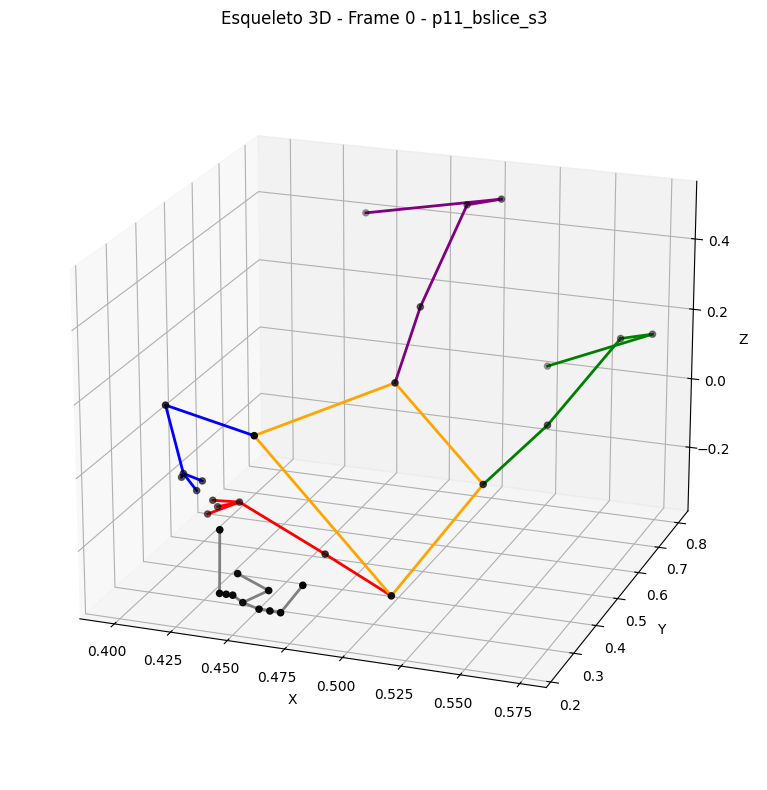

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Save to file in configs/stgcn/ folder
keypoints_path = "/content/all_keypoints.npz"

# Load the keypoints from the npz file and rebuild the dictionary organized by action and video
data = np.load(keypoints_path)
all_keypoints = {}
for key in data.files:
    action, video_file = key.split("__", 1)
    if action not in all_keypoints:
        all_keypoints[action] = {}
    all_keypoints[action][video_file] = data[key]

# Explore the data: available actions, sample video and keypoint format
print("Available actions:", list(all_keypoints.keys()))
first_action = list(all_keypoints.keys())[0]
first_video = list(all_keypoints[first_action].keys())[0]
print("Video example:", first_video)
print('Mediapipe shape: (Number of frames, Number of keypoints, Spatial coordinates)')
print("Format of keypoints:", all_keypoints[first_action][first_video].shape)

# Select the frame to view
frame_idx = 0
points = all_keypoints[first_action][first_video][frame_idx]  # shape: (num_joints, 3)

# Define anatomical connections (MediaPipe 33 points)
anatomical_connections = {
    'head': [
        (0, 1), (1, 2), (2, 3),
        (0, 4), (4, 5), (5, 6),
        (3, 7), (6, 8),
        (0, 9), (9, 10)
    ],
    'left_arm': [(11, 13), (13, 15), (15, 17), (15, 19), (15, 21)],
    'right_arm': [(12, 14), (14, 16), (16, 18), (16, 20), (16, 22)],
    'torso': [(11, 12), (23, 24), (11, 23), (12, 24)],
    'left_leg': [(23, 25), (25, 27), (27, 29), (29, 31)],
    'right_leg': [(24, 26), (26, 28), (28, 30), (30, 32)],
}

colors = {
    'head': 'gray',
    'left_arm': 'red',
    'right_arm': 'blue',
    'torso': 'orange',
    'left_leg': 'green',
    'right_leg': 'purple',
}

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2], c='black', s=20)

# Drawing anatomical connections
for part, connections in anatomical_connections.items():
    for i, j in connections:
        if i < len(points) and j < len(points):
            ax.plot(
                [points[i, 0], points[j, 0]],
                [points[i, 1], points[j, 1]],
                [points[i, 2], points[j, 2]],
                color=colors[part], linewidth=2
            )

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f"Esqueleto 3D - Frame {frame_idx} - {first_video}")
ax.view_init(elev=20, azim=-70)
plt.tight_layout()
plt.show()


## Obtain the training, test and validation samples for training

In [ ]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
import random


def extract_player_id(filename):
    """
    Extracts the player ID from the file name.

    Example: 'player1_video1.npy' → 'player1'

    Parameters:
      filename (str): The name of the file.

    """
    return filename.split('_')[0]

# Organize videos by player
player_video_map = defaultdict(list)
for action, videos in all_keypoints.items():
    for video_file in videos:
        player_id = extract_player_id(video_file)
        player_video_map[player_id].append((action, video_file))

# Split player IDs
players = list(player_video_map.keys())
random.shuffle(players)

train_end = int(len(players) * 0.7)
val_end = int(len(players) * 0.85)

train_players = players[:train_end]
val_players = players[train_end:val_end]
test_players = players[val_end:]

def collect_by_players(player_ids):
  """
  Collects all (keypoints, action) of the selected players

  Parameters:
    player_ids (list): List of player IDs.

  """
    dataset = []
    for pid in player_ids:
        for action, filename in player_video_map[pid]:
            keypoints = all_keypoints[action][filename]
            dataset.append((keypoints, action))
    return dataset

train_set = collect_by_players(train_players)
val_set = collect_by_players(val_players)
test_set = collect_by_players(test_players)

print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")


Train: 1368, Val: 288, Test: 324


## Prepare data to ST-GCN




In [ ]:
# Store keypoints in a numpy array with the shape [N, C, T, V, M]
# C = 3 (number of coordinates: x, y, z),
# T = 120 (our fixed number of frames),
# V = number of joints,
# M = 1 (number of people)


import pickle

# Defines the indexes of the 25 key points of the NTU RGB+D layout within the 33 points of the MediaPipe
ntu_joints_in_mediapipe = [
    0,   # Nose
    11,  # Left Shoulder
    12,  # Right Shoulder
    13,  # Left Elbow
    14,  # Right Elbow
    15,  # Left Wrist
    16,  # Right Wrist
    23,  # Left Hip
    24,  # Right Hip
    25,  # Left Knee
    26,  # Right Knee
    27,  # Left Ankle
    28,  # Right Ankle
    5,   # Right Eye
    2,   # Left Eye
    7,   # Left Ear
    8,   # Right Ear
    17,  # Left Pinky
    18,  # Right Pinky
    19,  # Left Index
    20,  # Right Index
    21,  # Left Thumb
    22,  # Right Thumb
    29,  # Left Foot Index
    30   # Right Foot Index
]

def filter_to_ntu_joints(keypoints):
    """
    Receives 33 keypoints as input and adapts them to the NTU RGB+D layout, returning only 25 keypoints.

    Parameters:
      keypoints (np.ndarray): Three-dimensional array of MediaPipe shape (T, 33, 3), where:
            - T (int): Number of frames in the video.
            - 33 (int): Number of keypoints (joints) detected by MediaPipe in each frame.
            - 3 (int): Spatial coordinates of each point (x, y, z).

    """
    return keypoints[:, ntu_joints_in_mediapipe, :]

def prepare_stgcn_data(dataset, label_map):
    """
    Prepares a list of keypoint data samples for training or evaluating the ST-GCN
    (Spatio-Temporal Graph Convolutional Network) model, formatting each sample as
    required by the MMAction2 library: a dictionary containing the keypoint array
    and metadata, where the keypoint data follows the shape [M, T, V, C]
    (M: number of people, T: number of frames, V: number of joints, C: coordinates x, y, z).

    Parameters:
      dataset (list of tuples):  List where each element is a tuple (keypoints, action_name).
      label_map (dict): Dictionary mapping action names to numerical labels.

    """
    data_list = []
    for i, (keypoints, action_name) in enumerate(dataset):
        keypoints = np.array(keypoints)  # (T, 33, C)
        keypoints = filter_to_ntu_joints(keypoints)  # (T, 25, C)
        num_frames, num_joints, channels = keypoints.shape
        # one person per sample:
        keypoints = keypoints[np.newaxis, ...]  # (M=1, T, V, C)
        sample = {
            'frame_dir': f'sample_{i}',
            'label': label_map[action_name],
            'img_shape': None,
            'total_frames': num_frames,
            'keypoint': keypoints,
        }
        data_list.append(sample)
    return data_list

# Creates a dictionary that maps each action to an integer (label)
label_map = {name: idx for idx, name in enumerate(sorted(set(a for _, a in train_set + val_set + test_set)))}

# Prepare and save training, validation and test datasets in pickle format
train_data = prepare_stgcn_data(train_set, label_map)
val_data = prepare_stgcn_data(val_set, label_map)
test_data = prepare_stgcn_data(test_set, label_map)

with open('/content/train_labels.pkl', 'wb') as f:
    pickle.dump(train_data, f)

with open('/content/val_labels.pkl', 'wb') as f:
    pickle.dump(val_data, f)


with open('/content/test_labels.pkl', 'wb') as f:
    pickle.dump(test_data, f)

print("Data saved successfully!")

Data saved successfully!


## Clone the MMAction2 repository

In [ ]:
!git clone https://github.com/open-mmlab/mmaction2.git mmaction2 #alterei
%cd mmaction2
!pip install -e .

Cloning into 'mmaction2'...
remote: Enumerating objects: 22864, done.
remote: Total 22864 (delta 0), reused 0 (delta 0), pack-reused 22864 (from 1)
Receiving objects: 100% (22864/22864), 69.62 MiB | 36.90 MiB/s, done.
Resolving deltas: 100% (16120/16120), done.
/content/mmaction2
Obtaining file:///content/mmaction2
  Preparing metadata (setup.py) ... done
  Attempting uninstall: mmaction2
    Found existing installation: mmaction2 1.2.0
    Uninstalling mmaction2-1.2.0:
      Successfully uninstalled mmaction2-1.2.0
  Running setup.py develop for mmaction2


## Import libraries to train the model

In [ ]:
!pip install --force-reinstall numpy==1.26.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtune 0.6.1 requires torchdata==0.11.0, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.35.2 which is incompatible.
pymc 5.22.0 requires rich>=13.7.1, but you have rich 13.4.2 which is incompatible.
pytensor 2.30.3 requires filelock>=3.15, but you have filelock 3.14.0 which is incompatible.
yfinance 0.2.61 requires requests>=2.31, but you have request

In [ ]:
import numpy
import torch
import mmcv
import mmengine
import mmaction2


## Custom Hook Configuration for partial ST-GCN fine-tuning in MMAction2

In [ ]:
# Creates a custom hook to freeze all ST-GCN layers except the last one (layers.9)
freez_code = """

from mmengine.registry import HOOKS
from mmengine.hooks import Hook

@HOOKS.register_module()
class FreezeSTGCNLayersHook(Hook):
    def before_train(self, runner):
        for name, param in runner.model.backbone.named_parameters():
            if 'layers.9' not in name:  # Ajusta conforme necessário
                param.requires_grad = False

"""

with open('/content/mmaction2/freeze_stgcn_layers_hook.py', 'w') as f:
    f.write(freez_code)


In [ ]:
import sys
sys.path.append('/content/mmaction2')


In [ ]:
# Define the experiment configuration file
# (model, pipelines, dataloaders, optimizer, hooks, val_evaluator, val_evaluator...)

config_code = """

_base_ = ['/content/mmaction2/configs/_base_/default_runtime.py']

model = dict(
    type='RecognizerGCN',
    backbone=dict(
        type='STGCN',
        graph_cfg=dict(
            layout='nturgb+d',  # layout NTU
            mode='stgcn_spatial'),
        in_channels=3  # keypoints 3D: x, y, z
    ),
    cls_head=dict(
        type='GCNHead',
        in_channels=256,
        num_classes=12)

)


custom_imports = dict(
    imports=['freeze_stgcn_layers_hook'],
    allow_failed_imports=False)

train_pipeline = [
    dict(type='PreNormalize3D'),
    dict(type='GenSkeFeat', dataset='nturgb+d', feats=['j']),
    dict(type='UniformSampleFrames', clip_len=100),
    dict(type='PoseDecode'),
    dict(type='FormatGCNInput', num_person=1),
    dict(type='PackActionInputs')
]
val_pipeline = [
    dict(type='PreNormalize3D'),
    dict(type='GenSkeFeat', dataset='nturgb+d', feats=['j']),
    dict(type='UniformSampleFrames', clip_len=100, num_clips=1, test_mode=True),
    dict(type='PoseDecode'),
    dict(type='FormatGCNInput', num_person=1),
    dict(type='PackActionInputs')
]
test_pipeline = [
    dict(type='PreNormalize3D'),
    dict(type='GenSkeFeat', dataset='nturgb+d', feats=['j']),
    dict(type='UniformSampleFrames', clip_len=100, num_clips=1, test_mode=True),
    dict(type='PoseDecode'),
    dict(type='FormatGCNInput', num_person=1),
    dict(type='PackActionInputs')
]


train_dataloader = dict(
    batch_size=4,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=True),
    dataset=dict(
        type='PoseDataset',
        ann_file='/content/train_labels.pkl',
        pipeline=train_pipeline
    )
)
val_dataloader = dict(
    batch_size=4,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type='PoseDataset',
        ann_file='/content/val_labels.pkl',
        pipeline=val_pipeline
    )
)
test_dataloader = dict(
    batch_size=4,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type='PoseDataset',
        ann_file='/content/test_labels.pkl',
        pipeline=test_pipeline
    )
)

val_evaluator = [dict(type='AccMetric')]
test_evaluator = val_evaluator

optim_wrapper = dict(
    optimizer=dict(
        type='SGD', lr=0.1, momentum=0.9, weight_decay=0.0005, nesterov=True)
)


train_cfg = dict(
    type='EpochBasedTrainLoop', max_epochs=10, val_begin=1, val_interval=1)

val_cfg = dict(type='ValLoop')
test_cfg = dict(type='TestLoop')


custom_hooks = [
    dict(
        type='FreezeSTGCNLayersHook',
        priority='VERY_HIGH'
    )
]



# Salvar checkpoints, logs, etc.
work_dir = '/content/drive/MyDrive/mmaction2_work_dir/stgcn_treino'

load_from = 'https://download.openmmlab.com/mmaction/v1.0/skeleton/stgcn/stgcn_8xb16-joint-u100-80e_ntu60-xsub-keypoint-3d/stgcn_8xb16-joint-u100-80e_ntu60-xsub-keypoint-3d_20221129-850308e1.pth'

"""



# Save to file with the configuration
with open('/content/mmaction2/configs/stgcn_3d_custom.py', 'w') as f:
    f.write(config_code)





In [ ]:
# Set up Google Drive to save checkpoints and experiment logs
from google.colab import drive
import os
drive.mount('/content/drive')


save_path = '/content/drive/MyDrive/mmaction2_work_dir/stgcn_treino'
os.makedirs(save_path, exist_ok=True)


Mounted at /content/drive


## Start the training using the official MMAction2 script

In [ ]:
!python /content/mmaction2/tools/train.py /content/mmaction2/configs/stgcn_3d_custom.py


05/27 19:10:26 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1054596268
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_

## Start the test using the official MMAction2 script

In [ ]:
!python /content/mmaction2/tools/test.py /content/mmaction2/configs/stgcn_3d_custom.py /content/drive/MyDrive/mmaction2_work_dir/stgcn_treino/epoch_10.pth --dump /content/drive/MyDrive/mmaction2_work_dir/stgcn_test/results.pkl


05/27 19:15:20 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 788213538
    GPU 0: Tesla T4
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 12.5, V12.5.82
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_3

## Confusion Matrix of the Test Results for the Trained ST-GCN Model

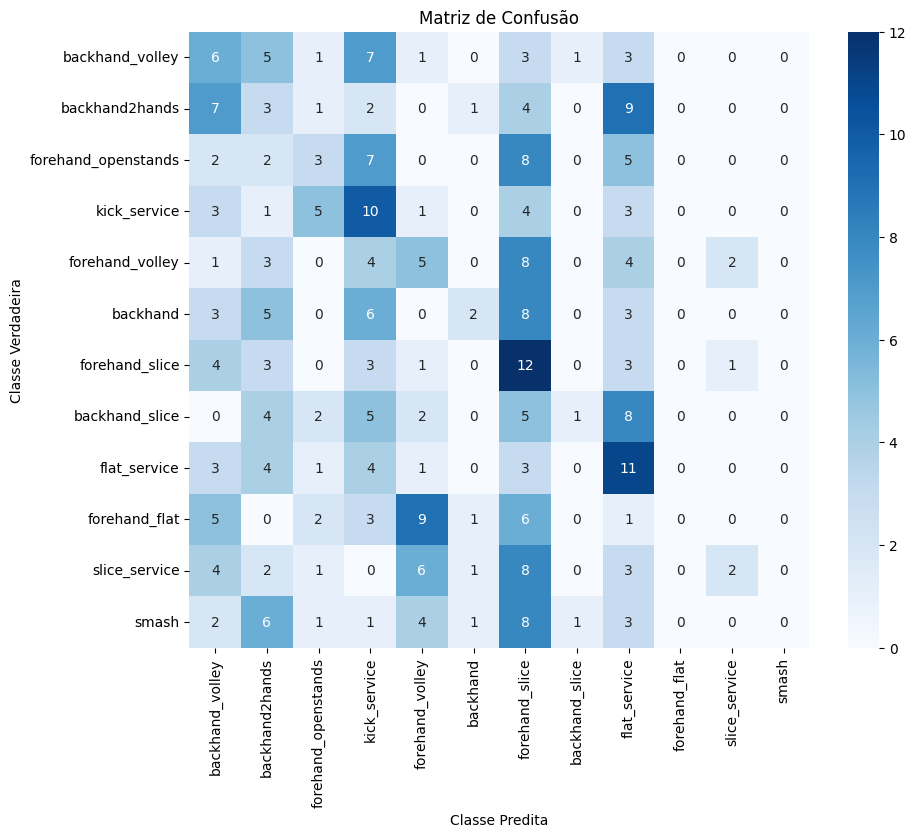

In [ ]:
import pickle
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho para o ficheiro de resultados
results_path = '/content/drive/MyDrive/mmaction2_work_dir/stgcn_test/results.pkl'

# Carrega as predições
with open(results_path, 'rb') as f:
    results = pickle.load(f)

# results é normalmente uma lista de arrays de scores por classe
# Para cada amostra, o índice do maior score é a predição do modelo
# y_pred = [np.argmax(r) for r in results]

y_pred = [int(r['pred_label'].item()) if hasattr(r['pred_label'], 'item') else int(r['pred_label']) for r in results]


# Agora precisas dos rótulos verdadeiros (labels do dataset de teste)
# Supondo que tens um ficheiro ann_file com os labels:
import mmcv
ann_file = '/content/test_labels.pkl'

import pickle

with open('/content/test_labels.pkl', 'rb') as f:
    data_infos = pickle.load(f)


# y_true = [info['label'] for info in data_infos]

y_true = [int(r['gt_label'].item()) if hasattr(r['gt_label'], 'item') else int(r['gt_label']) for r in results]


# Calcula a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

class_labels = [
'backhand_volley', 'backhand2hands', 'forehand_openstands', 'kick_service', 'forehand_volley', 'backhand', 'forehand_slice', 'backhand_slice', 'flat_service', 'forehand_flat', 'slice_service', 'smash']

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Verdadeira')
plt.title('Matriz de Confusão')
plt.savefig('matriz_confusao.png', bbox_inches='tight')
plt.show()
